In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
from scipy import sparse
from scipy.sparse import csr_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('movielens-fds'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

movielens-fds/training.csv
movielens-fds/test.csv
movielens-fds/sample_submission.csv


In [3]:
def evaluate(predict_f,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.05)),
                                   replace=False)
    df['for_testing'] = False
    df.loc[sampled_ids, 'for_testing'] = True
    return df


In [9]:
def get_x(user_id, movie_id, dummie_idx_users, dummie_idx_movies, N_dummies):
    hot_user = dummie_idx_users[user_id] ; hot_movie = dummie_idx_movies[movie_id]
    row = np.array([0,0]) ; col = np.array([hot_user,hot_movie]) ; data = np.array([1, 1]) 
    x = csr_matrix((data, (row, col)), shape=(1, N_dummies))
    return x

def evaluate2(predict_f, data_test, users_index, movies_index, mean_rating, dummie_idx_users, dummie_idx_movies, N_dummies):
    
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = []
    
    for u,i in ids_to_estimate:
        if u not in users_index and i in movies_index:
            estimated.append(3)
        
        if u in users_index and i in movies_index:
            x = get_x(u,i,dummie_idx_users,dummie_idx_movies,N_dummies)
            estimated.append(predict_f(x))
            
        if i not in movies_index:
            estimated.append(mean_rating) # this is a new movie

    real = data_test.rating.values
    return compute_rmse(estimated, real)
    

In [10]:
df = pd.read_csv('./movielens-fds/training.csv')
df.head()

grouped    = df.groupby('user_id', group_keys=False).apply(assign_to_set)
df_train = df[grouped.for_testing == False]
df_val   = df[grouped.for_testing == True]

In [11]:
class RecSys_fm4():
    """ Collaborative filtering using a custom sim(u,u'). """

    def __init__(self,df_train,df_val, num_components=10):
        """ Constructor """
        self.df_train       = df_train
        self.df_val         = df_val
        self.num_components = num_components
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        self.N_samples = len(self.df_train)
        self.users_index  = set(self.df_train.user_id)
        self.movies_index = set(self.df_train.movie_id)
        self.N_users      = len(self.users_index) 
        self.N_movies     = len(self.movies_index)
        self.N_dummies = self.N_users + self.N_movies  
        self.dummie_idx_users  = dict(zip(self.users_index, range(self.N_users)))
        self.dummie_idx_movies = dict(zip(self.movies_index, range(self.N_users,self.N_users+self.N_movies)))
        
    def __sdg__(self):
        l = []
        for idx in self.training_indices:
            l.append(idx)
            if len(l)%1000 == 0: print('Wait {} idxs'.format(len(self.training_indices)-len(l)))
            y     = np.array(self.df_train.iloc[idx,3]) 
            user  = self.df_train.iloc[idx,:].user_id
            movie = self.df_train.iloc[idx,:].movie_id
            x     = get_x(user, movie, self.dummie_idx_users, self.dummie_idx_movies, self.N_dummies)
            
            prediction = self.predict(x)
            loss_derivative = 2*(prediction-y)
            #Update w0
            grad_w0 = loss_derivative
            self.w0 = self.w0 - self.learn_rate * (grad_w0 + 2*self.lmbda * self.w0)

            for i in x.indices:
                grad_w = loss_derivative * x[0,i]
                self.w[i] = self.w[i] - self.learn_rate*(grad_w + 2*self.lmbda*self.w[i])

                for f in range(self.num_components):
                    grad_V = loss_derivative*x[0,i]*(sum(x*self.V[:, f]) - x[0,i]*self.V[i, f])
                    self.V[i, f] = self.V[i, f] - self.learn_rate * (grad_V + 2*self.lmbda*self.V[i, f])
            
    def fit(self,n_epochs = 10,learning_rate =0.01,lmbda=0.1,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learn_rate = learning_rate
        self.lmbda = lmbda
        
        self.mean_rating = self.df_train.rating.mean() 
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize model parameters
        self.w0 = self.mean_rating
        self.w  = np.random.normal(scale=1./self.N_dummies, size=self.N_dummies)
        self.V  = np.random.normal(scale=1./self.num_components, size=(self.N_dummies, self.num_components))
        
        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.N_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate2(self.predict,self.df_train, self.users_index, self.movies_index, self.mean_rating, self.dummie_idx_users, self.dummie_idx_movies,self.N_dummies))
            self.test_rmse.append(evaluate2(self.predict,self.df_val, self.users_index, self.movies_index, self.mean_rating, self.dummie_idx_users, self.dummie_idx_movies,self.N_dummies))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, x):
        """ Single user and item prediction."""
        sx = 0 ; dx = 0 ; linear = 0
        
        for i in x.indices:
            sx += self.V[i,:]*x[0,i]
            dx += (self.V[i,:]**2)*x[0,i]**2
            linear += self.w[i]*x[0,i]
    
        interact  = sum(sx**2 - dx)/2 

        return self.w0 + linear + interact
    

In [12]:
df_train_red = df_train[df_train.user_id < 10] 
df_val_red = df_val[df_val.user_id < 10]

Epoch: 0
	Train rmse: 1.2089880483132631
	Test rmse: 1.099594857324397
Epoch: 1
	Train rmse: 1.1319321394383126
	Test rmse: 1.056859453760445
Epoch: 2
	Train rmse: 1.115815786480951
	Test rmse: 1.0647624625473684
Epoch: 3
	Train rmse: 1.0957425048370426
	Test rmse: 1.0659868588871086
Epoch: 4
	Train rmse: 1.0691900485179469
	Test rmse: 1.0605674345506675
Epoch: 5
	Train rmse: 1.015791696798062
	Test rmse: 1.0436837147919065
Epoch: 6
	Train rmse: 1.0258951648904935
	Test rmse: 1.0640732602375798
Epoch: 7
	Train rmse: 0.9797099746951075
	Test rmse: 1.0544656133646362
Epoch: 8
	Train rmse: 1.069307725952652
	Test rmse: 1.0916580657770851
Epoch: 9
	Train rmse: 0.908086306458356
	Test rmse: 1.0423320473560629


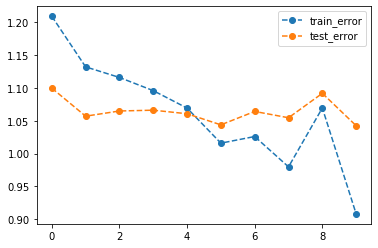

In [13]:
reco = RecSys_fm4(df_train_red,df_val_red,num_components=5)
reco.fit()